# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   :May 30th 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [1]:
#%%javascript
#var kernel = IPython.notebook.kernel;
#var thename = window.document.getElementById("notebook_name").innerHTML;
#var command = "theNotebook = " + "'"+thename+"'";
#kernel.execute(command);

In [2]:
#print theNotebook

In [3]:
theNotebook="FindCentralStar"

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [5]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [6]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [7]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [8]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [9]:
%load_ext Cython

In [10]:
from IPython.display import Image, display

In [11]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [12]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [13]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [14]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [15]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [16]:
inputdir="reduced_fitsimages"
MIN_IMGNUMBER=46
MAX_IMGNUMBER=55
object_name='HD111980 May 31th 2017'
SelectTagRe='^reduc_20170531_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^reduc_20170531_[0-9]+.fits$'
NBIMGPERLROW=4
BigFigSize=(20,100)

### Output directory fot fits images

In [17]:
outputdir="./cut_fitsimages"

In [18]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [19]:
input_filelist=os.listdir(inputdir) 

In [20]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [21]:
print input_filelist[:5]

['reduc_20170531_046.fits' 'reduc_20170531_047.fits'
 'reduc_20170531_048.fits' 'reduc_20170531_049.fits'
 'reduc_20170531_050.fits']


In [22]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [23]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [24]:
MakeFileList()   # Make the list

In [25]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [26]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [27]:
sorted_numbers=indexes_files[sorted_indexes]

In [28]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [29]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [30]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [31]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [32]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [33]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [34]:
#all_filt

## Show images
-----------------------

In [35]:
len(all_images)

10

In [36]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=BigFigSize)
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    #plt.savefig(figfilename)   

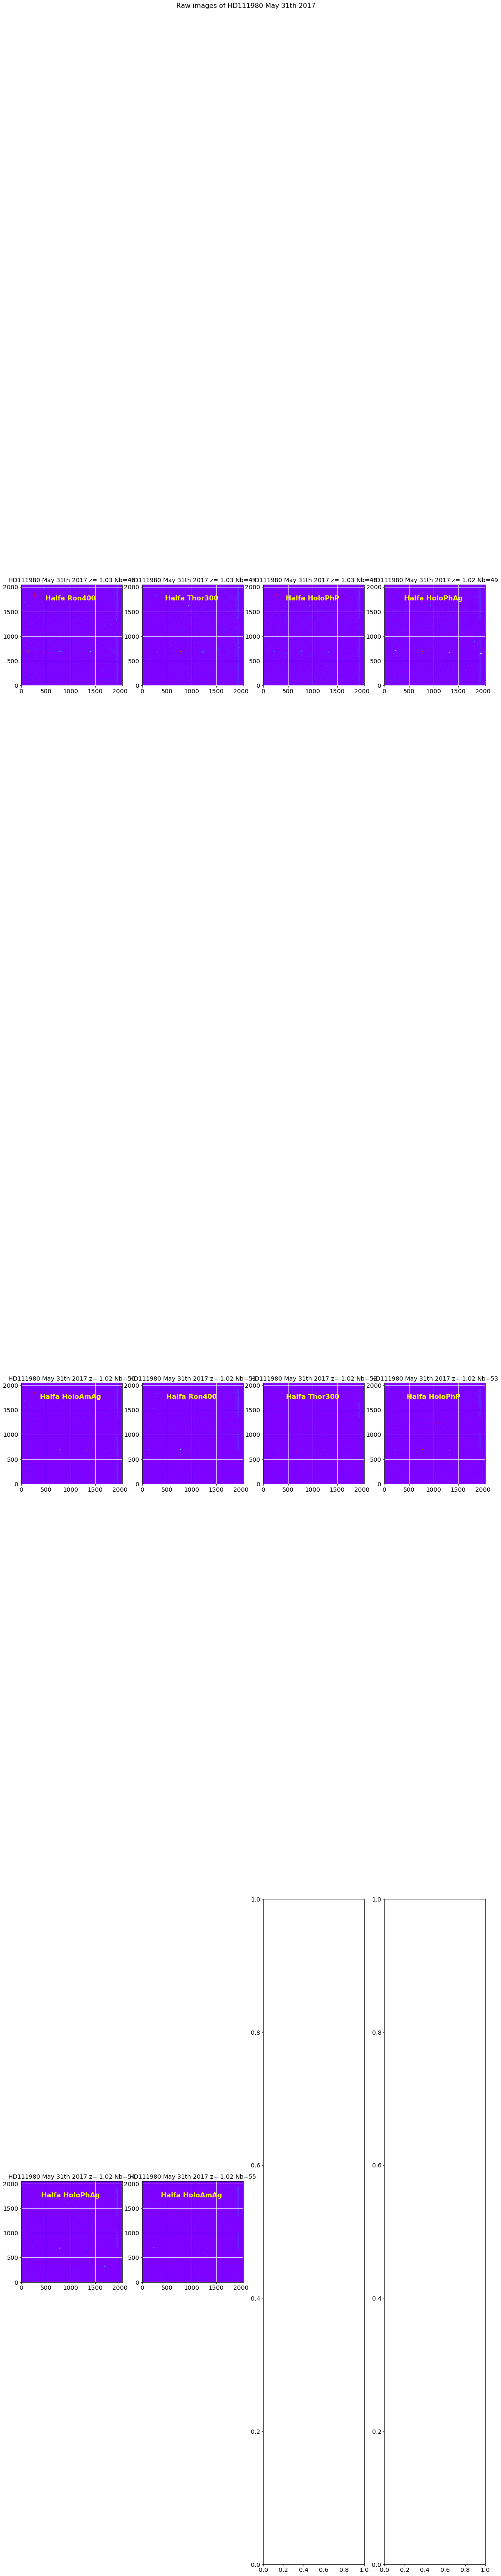

In [37]:
ShowRawImages()

### Find the star locations
----------------------------

In [38]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=50.0, threshold=1000*std)
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [39]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
import numpy as np

def ComputeStatImagesFast(all_images,minx=500,maxx=1000,miny=500,maxy=1000):
    """
    ComputeStatImagesFast: 
    =======================
    
    - preselection of a sub-image
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    shiftx=minx
    shifty=miny
    for image in all_images:
        subimage=np.copy(image[miny:maxy,minx:maxx])
        subimage.shape
        mean, median, std = sigma_clipped_stats(subimage, sigma=5.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(subimage - median, fwhm=50.0, threshold=50*std)
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources,shiftx,shifty

In [40]:
#img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

In [41]:
img_mean,img_median,img_std,img_sources,shiftx,shifty=ComputeStatImagesFast(all_images)

----------------------------------------------------------------
0  mean, median, std =  6.29803717526 6.18121098276 5.57143065731


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--- --------- --------- --------- ---------- ---------- ---- --- ---- ---- ---
----------------------------------------------------------------
1  mean, median, std =  4.96727566386 4.81810242822 5.42661075881
 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--- --------- --------- --------- ---------- ---------- ---- --- ---- ---- ---
----------------------------------------------------------------
2  mean, median, std =  6.45149611384 6.25570361417 5.71906106584
 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--- --------- --------- --------- ---------- ---------- ---- --- ---- ---- ---
----------------------------------------------------------------
3  mean, median, std =  6.16295144432 6.1018630188 5.64407157468
 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--- --------- --------- --------- ---------- ----------

In [42]:
sel=0

In [43]:
thesource=img_sources[sel]
img_size=all_images[sel].shape

In [44]:
print thesource

 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--- --------- --------- --------- ---------- ---------- ---- --- ---- ---- ---


In [45]:
x_star=thesource["xcentroid"]
y_star=thesource["ycentroid"]
points_set=np.array(zip(x_star,y_star))

### Default value 

- if no source were found

In [46]:
x0=x_star[0]
y0=y_star[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print 'x0,y0=',x0,y0

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

In [ ]:
x0,y0=779.116578702,699.947806179

### Search the main central star
----------------------------------

In [ ]:
%%cython
import numpy as np

"""
Set of routine to find the right position of the main central star
"""
def distance(v1,v2): 
    return sum([(x-y)**2 for (x,y) in zip(v1,v2)])**(0.5)

def GetDistanceSum(thepoint, points_set):
    """
    Return the distance sum of the point thepoit to the set of points points_set
    """
    dist_sum=0
    for otherpoint in points_set:
        dist= distance(thepoint,otherpoint)
        dist_sum+=dist
    return dist_sum

def GetAllDistanceSum(all_points):
    """
    Return the set of the distance sum to other point for all points
    """
    all_distances = []
    for thepoint in all_points:
        dist=GetDistanceSum(thepoint, all_points)
        all_distances.append(dist)
    all_distances=np.array(all_distances)
    return all_distances
        

def GetCentralPosition( x_star, y_star,x0,y0):
    """
    Find the position of the point which minimise the distance sum wrt other points
    """
    
    if x_star.size == 0:
        return np.array([int(y0),int(x0)])
        
    if x_star.size == 1:
        central_pos_index=0
        points_set=np.array(zip(x_star,y_star))
        return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])
    
    points_set=np.array(zip(x_star,y_star))
    distances_sum=GetAllDistanceSum(points_set)
    central_pos_index=np.where(distances_sum==distances_sum.min())[0][0]
    return np.array([int(points_set[central_pos_index][1]),int(points_set[central_pos_index][0])])

### Special way to find the right center of the main star

In [ ]:
positions_central = []
index=0
for source in img_sources:
    x_star=source["xcentroid"]
    y_star=source["ycentroid"]
    flux=source["flux"]
    position=GetCentralPosition(x_star,y_star,x0,y0)
    print position
    positions_central.append(position)
    index+=1

In [ ]:
positions_central=

### Cut the image
------------------

In [ ]:
DeltaY=200
DeltaX=600

In [ ]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=BigFigSize)
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

In [ ]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [ ]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
data[:,DeltaX-ws:DeltaX+ws]=0

In [ ]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [ ]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

In [ ]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^reduc_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

### Save outputfilename

In [ ]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)

In [ ]:
!ls -l cut_fitsimages/*